<a href="https://colab.research.google.com/github/prysykes/adversarial_attacks/blob/main/deepfool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
#!pip install -Uqq ipdb
# import ipdb

In [3]:
# pathh = 'MNISTClassifier'

# for parent, dirs, files in os.walk(pathh, topdown=False):
#   for file in files:
#     file_path = os.path.join(parent, file)
#     os.remove(file_path)
#   for dir in dirs:
#     dir_path = os.path.join(parent, dir)
#     os.rmdir(dir_path)
  
#   os.rmdir('/content/MNISTClassifier')

In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [4]:
(images, labels), (test_images, test_labels) = mnist.load_data() 
images = images.reshape((60000, 28, 28)).astype("float32") / 255
images = np.expand_dims(images, axis=3)
test_images = test_images.reshape((10000, 28, 28)).astype("float32") / 255
test_images = np.expand_dims(test_images, axis=3)
x_train, x_test = images[10000:], images[:10000]
y_train, y_test = labels[10000:], labels[:10000]

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
print(len(x_train))
x_train, x_val = x_train[10000:], x_train[0:10000]
y_train, y_val = y_train[10000:], y_train[0:10000]
print(len(x_train))

50000
40000


5


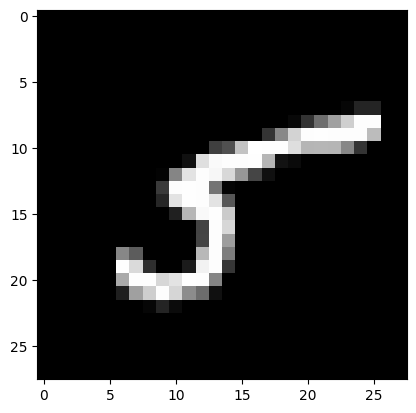

In [6]:
x_test[11].shape
digit = x_test[65]
fig = plt.figure
plt.imshow(digit, cmap='gray')
print(y_test[65])


In [7]:
few_twos = []
count = 0
for index, label in enumerate(y_test):
  if count > 4:
    break
  if label == 5:
    few_twos.append((index, label))
    count += 1

print(few_twos)

[(0, 5), (11, 5), (35, 5), (47, 5), (65, 5)]


In [8]:
class MNISTClassifier(tf.keras.Model):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        
        # Define the layers
        #for feature extration
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1))
        self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.25)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(10)
        self.layers_list = [self.conv1, self.max_pool1, self.conv2, self.max_pool2,
                           self.flatten, self.dropout1, self.dense1, self.dropout2, self.dense2]
    @tf.function
    def call(self, *args, **kwargs):
        # Define the forward pass
        # output is the model logits
        activation_list = []
        out = args[0]
        for layer in self.layers_list:                  
           out = layer(out)
           activation_list.append(out)

        # if kwargs['training']:
        #   #notice that training is a kw argument checked when fit is called
        #   #so when model is training, all I need is the output logits to call the loss function upon
        #   return out
        # else:          
          # prob = tf.nn.softmax(out)
        return out

In [ ]:
class SaveFinalTrainingLogitsProp(keras.callbacks.Callback):
  def on_train_end(self, logs):
    self.out = model.predict(x_train)
    self.prob = tf.nn.softmax(self.out)
    print(self.out.shape, self.prob.shape)

In [9]:
model = MNISTClassifier()
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

model.save('MNISTClassifier')
# model = keras.models.load_model("MNISTClassifier.keras")
model.summary()

Epoch 1/10
1250/1250 [==============================] - 18s 5ms/step - loss: 0.2815 - accuracy: 0.9120 - val_loss: 0.0709 - val_accuracy: 0.9764
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1000 - accuracy: 0.9700 - val_loss: 0.0454 - val_accuracy: 0.9852
Epoch 3/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.0774 - accuracy: 0.9765 - val_loss: 0.0416 - val_accuracy: 0.9866
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0627 - accuracy: 0.9804 - val_loss: 0.0346 - val_accuracy: 0.9882
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0554 - accuracy: 0.9835 - val_loss: 0.0342 - val_accuracy: 0.9893
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0482 - accuracy: 0.9847 - val_loss: 0.0322 - val_accuracy: 0.9898
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0432 - accuracy: 0.9865 - val_loss: 0.0257 - val_accuracy

Model: "mnist_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  320       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dropout (Dropout)           multiple             

In [10]:
# select a few twos from the test dataset and reshape
# twos are at [(5, 2), (16, 2), (25, 2), (28, 2), (76, 2)]

twos_tuple = [(0, 5), (11, 5), (35, 5), (47, 5), (65, 5)]
reshaped_sample_twos = []
for tup in twos_tuple:
  a_two = x_test[tup[0]]
  a_two = np.reshape(a_two, (-1, 28, 28, 1))
  reshaped_sample_twos.append(a_two)
reshaped_sample_twos = np.array(reshaped_sample_twos)
# a_five = np.reshape(x_test[47], (-1, 28, 28, 1))
# print(a_five.shape)

In [11]:
print(reshaped_sample_twos.shape) #the network expects a rank 4 tensor ie. batch, width, hieght, channel

(5, 1, 28, 28, 1)


In [12]:
model = tf.keras.models.load_model('MNISTClassifier')

In [13]:
# location of 2 in x_test # number 2 are found in these location: [(5, 2), (16, 2), (25, 2), (28, 2), (76, 2)]


prediction = []
for sample in reshaped_sample_twos:
  sample_prediction = model.predict(sample)
  prediction.append(sample_prediction)
# print(np.argmax(prediction))
print(np.argmax(prediction[0]))

1/1 [==============================] - 0s 20ms/step
5


In [14]:
print(tf.one_hot(y_test[11], 10)) #creates a 0n-hot encoded output label to enable us calculate the distance

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [15]:
reshaped_sample_twos[0].shape
#squeze to drop first dim
squeze_two = np.expand_dims(np.squeeze(reshaped_sample_twos[3]), axis=2)
squeze_two.shape
x = squeze_two
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(x)
y = y_test[5]
y = tf.convert_to_tensor(y)

print(y)
print(x.shape)

tf.Tensor(2, shape=(), dtype=uint8)
(1, 28, 28, 1)


In [91]:
def deepfool_attack(image, model, num_classes=10, overshoot=0.02, max_iter=2000):
  image_tensor = np.expand_dims(image, axis=0) #tf.convert_to_tensor(image[np.newaxis, ...], dtype=tf.float32)
  input_tensor = tf.Variable(image_tensor, dtype=tf.float32)
  # print("input_tensor", input_tensor)

  with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output = model(input_tensor) #output has the logits
    # print("output shape", output.flatten().shape)
    
    # print("output", output)
  
  f_image = tf.reshape(output, (-1,))
  # print("f_image shape", f_image)
  # print("f_image", f_image)
  num_classes = f_image.shape[0]
  # print("num classes", num_classes)
  grads = tape.gradient(output, input_tensor)
  grads = tf.squeeze(grads, axis=0)
  
  # print("grads", grads.shape)

  adv_image = np.copy(image)
  adv_label = np.argmax(output)
  # print("label", adv_label)
  

  for i in range(max_iter):
    print(f"step{i}")
    gradients = np.inf
    current_label = np.argmax(model.predict(adv_image[np.newaxis, ...])[0])
    # print("current label", current_label)

    for k in range(1, num_classes):
      w_k = grads[k] - grads[0]
      # print(f"grad_{k}", grads[k])
      f_k = f_image[k] - f_image[0]
      distance_k = abs(f_k) / np.linalg.norm(w_k)

      if distance_k < gradients:
        gradients = distance_k
        perturbation = (overshoot * w_k) / np.linalg.norm(w_k)
        # print("perturbation", perturbation)

    adv_image += perturbation

    adv_label = np.argmax(model.predict(adv_image[np.newaxis, ...])[0])


    if adv_label != current_label:
      break
  
  return tf.clip_by_value(adv_image, 0, 1), adv_label


In [40]:
# x = tf.squeeze(x, axis=0)
# x.shape

In [92]:
adv_img, adv_label = deepfool_attack(x, model)
# print(adv_img)

step0
1/1 [==============================] - 0s 37ms/step
step1
1/1 [==============================] - 0s 34ms/step
step2
1/1 [==============================] - 0s 41ms/step
step3
1/1 [==============================] - 0s 32ms/step
step4
1/1 [==============================] - 0s 36ms/step
step5
1/1 [==============================] - 0s 33ms/step
step6
1/1 [==============================] - 0s 27ms/step
step7
1/1 [==============================] - 0s 23ms/step
step8
1/1 [==============================] - 0s 25ms/step
step9
1/1 [==============================] - 0s 23ms/step
step10
1/1 [==============================] - 0s 24ms/step
step11
1/1 [==============================] - 0s 23ms/step
step12
1/1 [==============================] - 0s 23ms/step
step13
1/1 [==============================] - 0s 23ms/step
step14
1/1 [==============================] - 0s 28ms/step
step15
1/1 [==============================] - 0s 25ms/step
step16
1/1 [==============================] - 0s 29ms/step
step17


In [93]:
print(adv_img.shape)
print(adv_label)

(28, 28, 1)
4


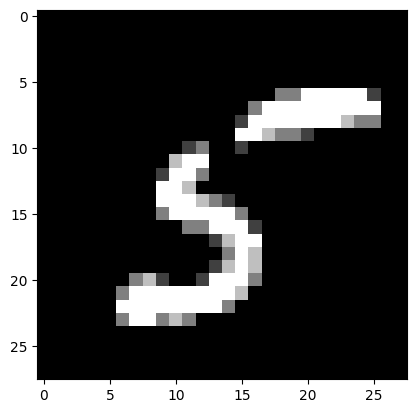

In [88]:
plt.imshow(x, cmap='gray')

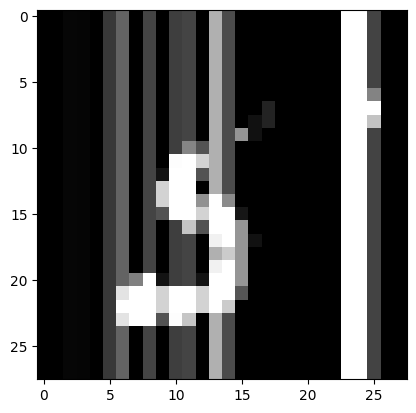

In [94]:
plt.imshow(adv_img, cmap='gray')